# Time-series diagnostics with nipy

In [1]:
# Import the numerical and plotting libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Show plots inside the notebook
%matplotlib inline

In [3]:
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [4]:
# - make numpy print numbers to 4dp only
np.set_printoptions(precision=4, suppress=True)

We first load the FMRI run image with the nipy library.

The FMRI image is 4D with the last dimension indexing brain volumes, ordered by time.

In [5]:
import nipy

In [6]:
img = nipy.load_image('ds114_sub009_t2r1.nii')
img.shape

(64, 64, 30, 173)

The image also has a coordinate map that gives the relationship between the voxel (array) coordinates and the coordinates in millimeters in the real world.  See the notebook on image slicing and http://nipy.org/nibabel/coordinate_systems.html for more detail:

In [7]:
img.coordmap

AffineTransform(
   function_domain=CoordinateSystem(coord_names=('i', 'j', 'k', 't'), name='voxels', coord_dtype=float64),
   function_range=CoordinateSystem(coord_names=('scanner-x=L->R', 'scanner-y=P->A', 'scanner-z=I->S', 't'), name='scanner', coord_dtype=float64),
   affine=array([[  -4.    ,    0.    ,    0.    ,    0.    ,  124.244 ],
                 [   0.    ,    3.9345,    0.7207,    0.    , -103.4497],
                 [   0.    ,   -0.7207,    3.9346,    0.    ,  -33.4929],
                 [   0.    ,    0.    ,    0.    ,    2.5   ,    0.    ],
                 [   0.    ,    0.    ,    0.    ,    0.    ,    1.    ]])
)

We can get the image array data with the `get_data` method:

In [8]:
data = img.get_data()

In [9]:
data.shape

(64, 64, 30, 173)

This is a center slice (over the third dimension) from the first volume (first volume acquired in time):

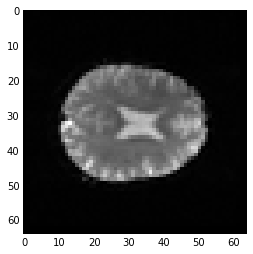

In [10]:
plt.imshow(data[:, :, 15, 0])

Nipy has a diagnostic screening routine, that runs some time-series diagnostics, including PCA and scan-to-scan difference measures:

In [11]:
from nipy.algorithms.diagnostics import screen, plot_tsdiffs

The measures come back as a dictionary with each value in the dictionary giving a different set of diagnostic results from this 4D image:

In [12]:
diagnostics = screen(img, slice_axis='k')

In [13]:
diagnostics.keys()

['std', 'min', 'max', 'ts_res', 'pca_res', 'pca', 'mean']

We first look at the time-series summary plots in the `ts_res` slot in the dictionary:

In [14]:
ts_res = diagnostics['ts_res']
ts_res.keys()

['slice_diff2_max_vol',
 'diff2_mean_vol',
 'volume_means',
 'slice_mean_diff2',
 'volume_mean_diff2']

Here we plot a set of four diagnostic time series.  The first is the volume-to-volume differences at each time point, given by subtracting the next volume from the current volume, and taking the mean sum of the squared difference values:

/Users/mb312/Library/Python/2.7/lib/python/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


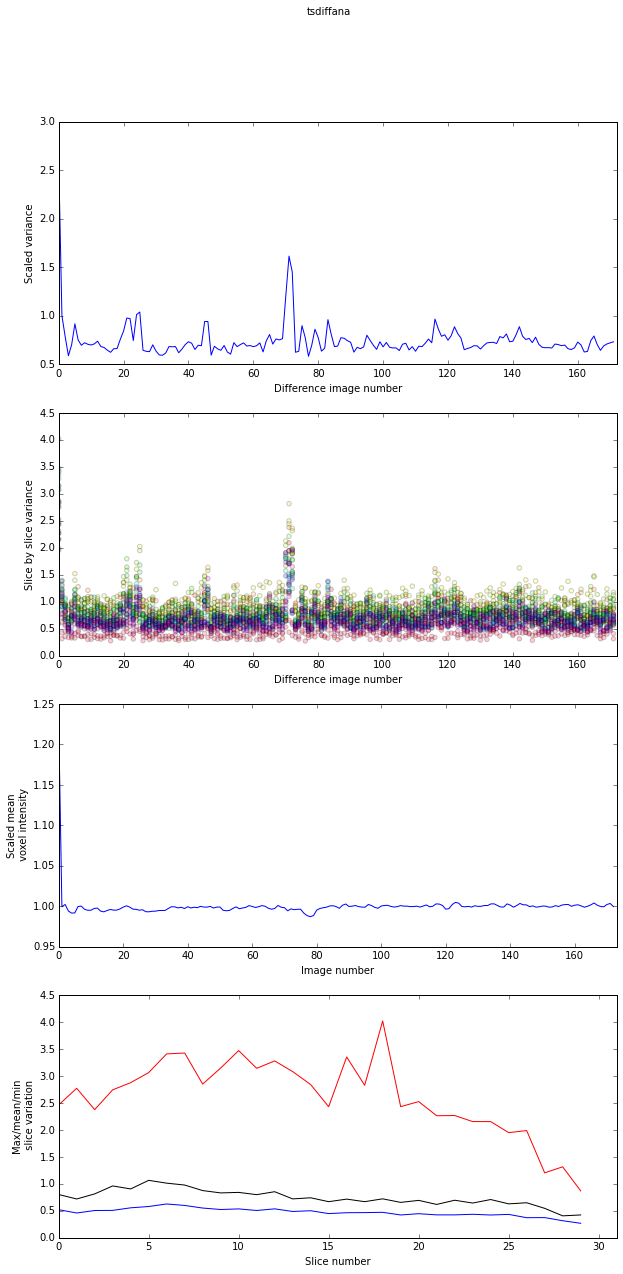

In [15]:
plt.figure(figsize=(10, 20))
axes = [plt.subplot(4, 1, i+1) for i in range(4)]
plot_tsdiffs(ts_res, axes)
plt.suptitle('tsdiffana')

Another diagnostic is the PCA of the image data, giving time signatures ("basis vectors") and their corresponding patterns in space ("basis projections").  This is useful to look for unexpected sources of high variance in the data:

In [16]:
pca_res = diagnostics['pca_res']
pca_res.keys()

['basis_vectors over 3',
 'axis',
 'basis_projections',
 'basis_vectors',
 'pcnt_var']

This is a plot of the first 10 basis vectors (time signatures) from the PCA, ordered by variance explained, highest basis vector first:

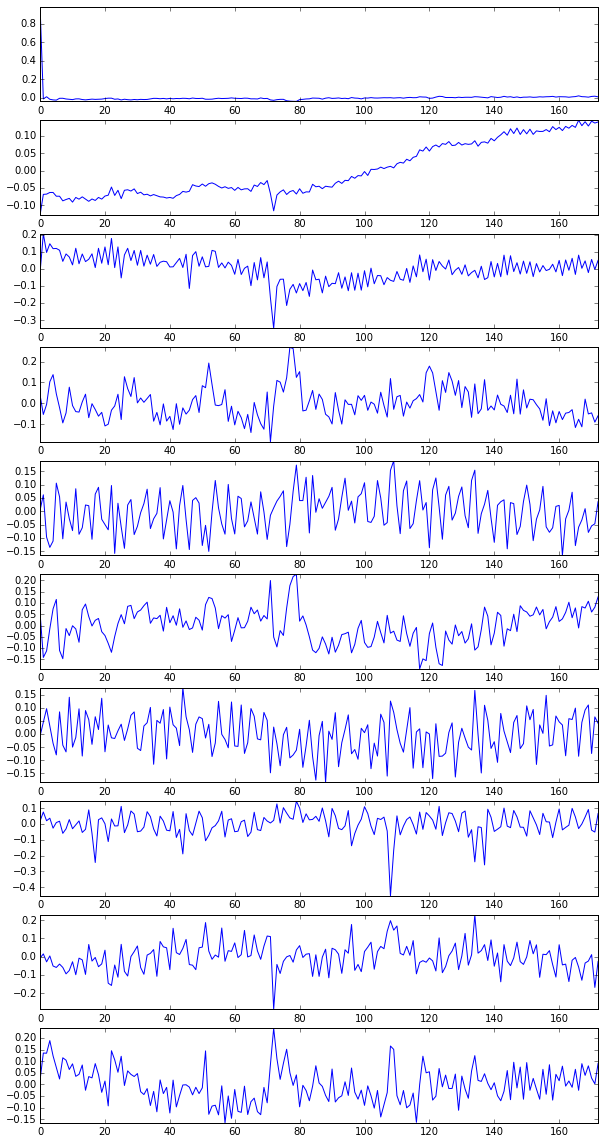

In [17]:
plt.figure(figsize=(10, 20))
n_comp = 10
for c in range(n_comp):
    plt.subplot(n_comp, 1, c+1)
    plt.plot(pca_res['basis_vectors'][:,c])
    plt.axis('tight')

The first basis vector has dected that the first scan is very different from the subsequent scans.   This time difference has the following pattern in voxels:

In [18]:
projections = pca_res['basis_projections']
projections.shape

(64, 64, 30, 10)

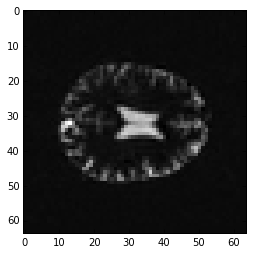

In [19]:
plt.imshow(projections.get_data()[:, :, 15, 0])

Nipy also provides these diagnostics as a command-line script.  It runs the diagnostics and writes out the results as NIfTI brain images, and PNG image files:

In [20]:
!nipy_diagnose ds114_sub009_t2r1.nii

/Users/mb312/Library/Python/2.7/lib/python/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)
/Users/mb312/Library/Python/2.7/lib/python/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


Among the written PNG files is a plot of the first 10 basis vectors, like the plot above:

In [21]:
ls *ds114*.png

components_ds114_sub009_t2r1.png  tsdiff_ds114_sub009_t2r1.png
pcnt_var_ds114_sub009_t2r1.png


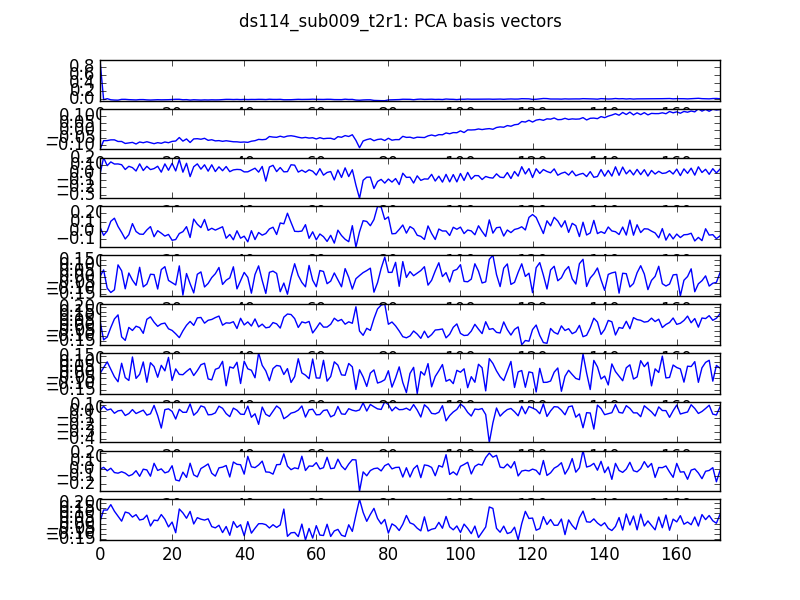

In [22]:
from IPython.display import Image
Image(filename='components_ds114_sub009_t2r1.png')

This being Python, we can go on and explore the 4D image interactively, to try and understand the difference detected in the diagnostics.  For example, here is the center slice (over the third dimension) for each of the first 5 volumes, showing the change in time deteced by the PCA first component (basis vector):

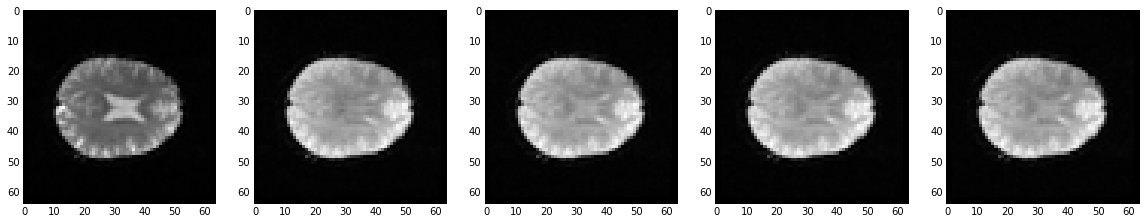

In [23]:
n_imgs = 5
fig, axes = plt.subplots(1, n_imgs, figsize=(20, 20))
for i in range(n_imgs):
    axes[i].imshow(data[:, :, 15, i])